In [79]:
import numpyro
numpyro.set_host_device_count(4)

import numpy as np
import jax.random as random
import matplotlib.pyplot as plt
import jax.numpy as jnp

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_median, init_to_feasible, init_to_sample
from tqdm import trange
from scipy.stats import norm

from jax.scipy.special import erf
from quadax import simpson


def generate_mock_sample(seed, N=50, slope=2.5, intercept=-1.0, xerr=1., yerr=1.0, xmin=-10, xmax=10, ymax=None):
    gen = np.random.default_rng(seed)

    x_true = gen.uniform(xmin, xmax, N)
    x_obs = gen.normal(x_true, xerr)
    y_obs = gen.normal(slope * x_true + intercept, yerr)

    mask = np.ones_like(y_obs, dtype=bool)
    if ymax is not None:
        mask &= y_obs <= ymax

    return x_obs[mask], y_obs[mask]


def get_log_S(slope, intercept, xmin, xmax, ymax, yerr):
    y = jnp.linspace(-10, 5, 1000)
    pdet = (erf((intercept + xmax * slope - y) / (np.sqrt(2) * yerr)) - erf((intercept + xmin * slope - y) / (np.sqrt(2) * yerr))) / (2 * slope)
    pdet = jnp.where(y <= ymax, pdet, 0)

    return jnp.log(simpson(pdet, x=y))

def linear_model(x, y, xerr, yerr, xmin, xmax , ymax):
    slope = numpyro.sample("slope", dist.Uniform(0.1, 5))
    intercept = numpyro.sample("intercept", dist.Uniform(-5, 5))

    log_S = get_log_S(slope, intercept, xmin, xmax, ymax, yerr)
    numpyro.factor("log_S", - len(x) * log_S)

    # numpyro.factor("log_S", + 0.7 * len(x) * jnp.log(jnp.abs(slope)))

    with numpyro.plate("data", len(x)):
        xtrue = numpyro.sample("x_true", dist.Uniform(xmin, xmax))
        numpyro.sample("ll_x", dist.Normal(xtrue, xerr), obs=x)
        numpyro.sample("ll_y", dist.Normal(slope * xtrue + intercept, yerr), obs=y)
        # numpyro.sample("ll_y", dist.TruncatedNormal(slope * xtrue + intercept, yerr, high=ymax), obs=y)

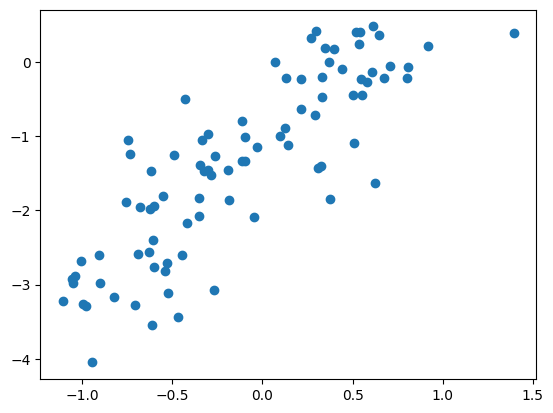

In [80]:
mock_kwargs = dict(N=100, slope=2.5, intercept=-1.0, xerr=0.25, yerr=0.5, xmin=-1, xmax=1, ymax=0.5)

x, y = generate_mock_sample(seed=42, **mock_kwargs)

plt.figure()
plt.scatter(x, y, label="Data")
plt.show()

In [88]:
num_warmup = 500
num_steps = 5000
slope_bias = []
intercept_bias = []

nrepeat = 10
progress_bar = nrepeat == 1

kernel = NUTS(linear_model, init_strategy=init_to_sample())
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_steps,
            num_chains=4, progress_bar=progress_bar)

for i in trange(nrepeat, disable=progress_bar):
    x, y = generate_mock_sample(seed=i, **mock_kwargs)

    mcmc.run(random.PRNGKey(i), x=x, y=y, xerr=mock_kwargs['xerr'], yerr=mock_kwargs['yerr'], xmin=mock_kwargs['xmin'], xmax=mock_kwargs['xmax'], ymax=mock_kwargs['ymax'])
    samples = mcmc.get_samples()

    if nrepeat == 1:
        mcmc.print_summary()

    slope_bias.append((samples["slope"].mean() - mock_kwargs['slope']) / samples["slope"].std())
    intercept_bias.append((samples["intercept"].mean() - mock_kwargs['intercept']) / samples["intercept"].std())

slope_bias = np.asarray(slope_bias)
intercept_bias = np.asarray(intercept_bias)

100%|██████████| 10/10 [02:45<00:00, 16.52s/it]


In [89]:
slope_bias

array([ 3.9041084e-01, -6.3273633e-01,  1.3197891e+00, -1.5023804e-03,
       -1.5158945e+00, -4.7429961e-01, -5.6313241e-01,  1.1362109e+00,
       -1.1720310e+00, -1.8950468e+00], dtype=float32)

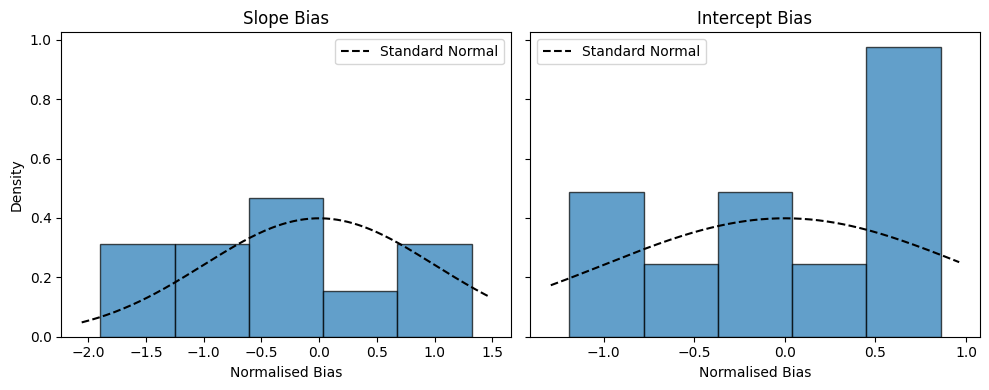

In [90]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# Normalised histograms
bins = "auto"
axes[0].hist(slope_bias, bins=bins, density=True, edgecolor='black', alpha=0.7)
axes[0].set_title('Slope Bias')
axes[0].set_xlabel('Normalised Bias')
axes[0].set_ylabel('Density')

axes[1].hist(intercept_bias, bins=bins, density=True, edgecolor='black', alpha=0.7)
axes[1].set_title('Intercept Bias')
axes[1].set_xlabel('Normalised Bias')

# Overlay standard normal PDF over current x-limits
for ax in axes:
    xlim = ax.get_xlim()
    x_plot = np.linspace(xlim[0], xlim[1], 300)
    ax.plot(x_plot, norm.pdf(x_plot), color='black', linestyle='--', label='Standard Normal')
    ax.legend()

plt.tight_layout()
plt.show()

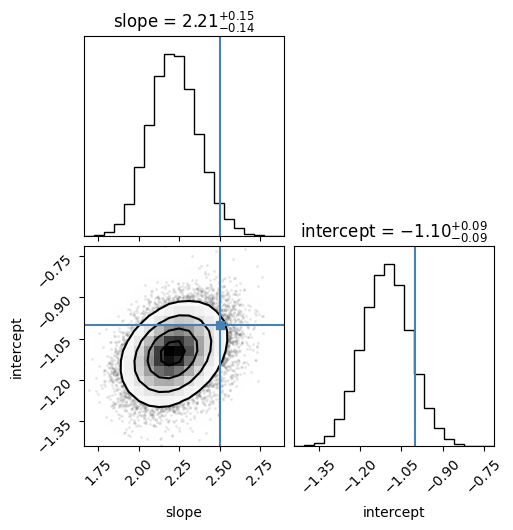

In [91]:
from corner import corner

param_names = ["slope", "intercept"]
data = np.vstack([samples[name] for name in param_names]).T

# 2. Make corner plot
figure = corner(
    data,
    labels=param_names,
    show_titles=True,
    title_fmt=".2f",
    truths=[mock_kwargs[p] for p in param_names],
    smooth=1.0
)

plt.show()